# Using Logistic Regression to predict the likelihood of a loan default

                                                                                                       Tanya Naheta

## Executive Summary

This report provides an anaylsis of mortgage data in order to predict the likelihood of a loan default. A variety of methods will be used to analyze and interpret the data in order to build a model based on logistic regression. I investigated the logistic regression algorithm, fine tuned it to the provided data set and provided results using the training data set. The results from this report show that the model was quite successful at predicting the likelihood of a loan default. In doing the analysis of the provided data, I also discovered that interest rate, debt to income ratio and the original loan-to-value are some attributes that are higly correlated to the likelihood of a loan default meaning they were important features in building the model.

## Introduction

Predicting whether or not a loan will default can seem very daunting given that it likely depends on a variety of factors. However, if we were to isolate a few key factors and characteristics of a loan, we could likely build a model that accurately predicts whether or not a loan will default. This report will dive deeper into this exploration and try to highlight the key variables that closely correlate to the likelihood of a loan default.

These are the attributes available to us in the dataset:

* Channel       
* SellerName 
* OriginalInterestRate
* OriginalUnpaidPrincipal
* OriginalLoanTerm
* OriginationDate
* FirstPayment
* OriginalLoanToValue
* OriginalCombinedLoanToValue
* NumBorrowers
* DebtToIncomeRatio
* CreditScore
* FirstTimeHomeBuyer
* LoanPurpose
* PropertyType
* NumUnits
* OccupancyStatus
* PropertyState
* Zip
* MortgageInsurancePercentage
* ProductType
* CoBorrowerCreditScore
* MortgageInsuranceType
* RelocationMortgageIndicator
* ForeclosureDate: Valid date if the home was foreclosed otherwise null (Will be used as a target variable)

The goal of this anaylsis is to be able to accurately predict the loan default variable given the attributes provided to our algorithm. 

There are a couple of hypotheses that will be tested during this anaylsis as well. One of the hypothesis regarding this dataset is that the credit score will have an inverse correlation to the likelihood of a loan default. This is because people with a higher credit score should be in a more financially stable position and less likely to default. Another hypothesis is that the original interest rate on the loan will have a strong correlation to the likelihood of a loan default. This is because a higher interest rate would mean that borrowers have to pay off more money, making it harder for them to do so. We will be testing both of these hypotheses by comparing the aforementioned attributes with our target variable.

## Data Preparation

In [266]:
import pandas as pd

acquisition_columns = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

performance_columns = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];

acquisition_dataframe = pd.read_csv('Acquisition_2008Q1.txt', sep='|', names=acquisition_columns, index_col=False)
performance_dataframe = pd.read_csv('Performance_2008Q1.txt', sep='|', names=performance_columns, index_col=False)

In [267]:
print("Any duplicate Loan ID's in performance dataset?", performance_dataframe['LoanID'].duplicated().any())

Any duplicate Loan ID's in performance dataset? True


In [268]:
print("Any duplicate Loan ID's in acquisition dataset?", acquisition_dataframe['LoanID'].duplicated().any())

Any duplicate Loan ID's in acquisition dataset? False


Since there are duplicate Loan ID's in the performance dataset, we will need to take the latest entry so we get the most up to date information. We can remove all duplicates from the performance dataset as shown below.

In [269]:
performance_dataframe.drop_duplicates(subset="LoanID", keep="last", inplace=True)
print("Any duplicate Loan ID's in performance dataset?", performance_dataframe['LoanID'].duplicated().any())

Any duplicate Loan ID's in performance dataset? False


We have ensured that there are no duplicates in the performance dataset by keeping only the last and most up to date entry for the Loan ID's. Now, we can merge the two datasets together in order to be able to train our model. Since we are going to be predicting whether or not a loan will default, we will mainly use the acquisition dataset attributes to train our model. However, we need the target variable (whether the loan defaulted or not) from the performance dataset. So, we are going to drop the rest of the performance columns and merge only the 'ForeclosureDate' column based on the Loan ID.

In [270]:
# Drop all columns from performance dataframe apart from LoanID and ForeclosureDate
performance_dataframe = performance_dataframe.filter(['LoanID', 'ForeclosureDate'])

# Merge the two dataframes together
df = pd.merge(acquisition_dataframe, performance_dataframe, on='LoanID')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380845 entries, 0 to 380844
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   LoanID           380845 non-null  int64  
 1   Channel          380845 non-null  object 
 2   SellerName       380845 non-null  object 
 3   OrInterestRate   380844 non-null  float64
 4   OrUnpaidPrinc    380845 non-null  int64  
 5   OrLoanTerm       380845 non-null  int64  
 6   OrDate           380845 non-null  object 
 7   FirstPayment     380845 non-null  object 
 8   OrLTV            380845 non-null  int64  
 9   OrCLTV           380845 non-null  int64  
 10  NumBorrow        380791 non-null  float64
 11  DTIRat           369838 non-null  float64
 12  CreditScore      380371 non-null  float64
 13  FTHomeBuyer      380845 non-null  object 
 14  LoanPurpose      380845 non-null  object 
 15  PropertyType     380845 non-null  object 
 16  NumUnits         380845 non-null  int6

We have our combined dataframe that we can use to train our model! First, we need to fill in the missing values for ForeclosureDate and turn it into our target variable column. In order to do this, we can replace all rows with a foreclosure date with 1 and the rest with 0 (ie. if a foreclosure date is present, the loan was defaulted on.)

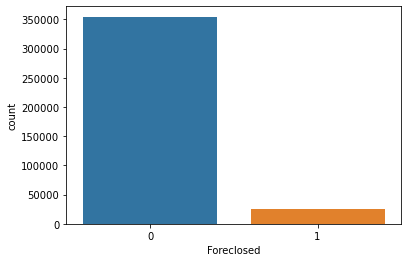

In [271]:
import seaborn as sns

df[['ForeclosureDate']] = df[['ForeclosureDate']].applymap(lambda x: 0 if pd.isnull(x) else 1)
# Change column name since it is now of type boolean
df.rename(columns={'ForeclosureDate': 'Foreclosed'}, inplace=True)

# Check to see the distribution of the target variable (ForeclosureDate)
sns.countplot(df['Foreclosed'])

Now that we have changed the column name and replaced the dates with 1's and 0's, we can plot the target variable to see the spread of the values. From the plot above, we see that the amount of foreclosed homes is very low compared to the amount of homes that were not foreclosed on. This is not ideal since it might incorrectly train our model to skew towards homes that were not foreclosed. In order to correct this and have a balance of these values, we can up-sample our minority class to ensure our model does not skew one way or another. (Chawla, 326)

In [272]:
# Find exact numbers of target variable distribution
df['Foreclosed'].value_counts()

0    354708
1     26137
Name: Foreclosed, dtype: int64

In [273]:
from sklearn.utils import resample

# Separate the majority and minority classes for our target variable
df_majority = df[df.Foreclosed==0]
df_minority = df[df.Foreclosed==1]

# For n_samples, we can pass in the number of loans that have Foreclosed set to 0. 
# This way we will have a balance between the values for our target variable.
df_upsampled_minority = resample(df_minority, 
                                 replace=True,
                                 n_samples=354708,
                                 random_state=123)

# Create a balanced dataframe
df = pd.concat([df_majority, df_upsampled_minority])
df['Foreclosed'].value_counts()

1    354708
0    354708
Name: Foreclosed, dtype: int64

We now have a balanced distribution for the target variable so we can continue analyzing the rest of the data.

In [274]:
# Output the amount of null values by column
df.isnull().sum(axis = 0)

LoanID                 0
Channel                0
SellerName             0
OrInterestRate         1
OrUnpaidPrinc          0
OrLoanTerm             0
OrDate                 0
FirstPayment           0
OrLTV                  0
OrCLTV                 0
NumBorrow            127
DTIRat             23811
CreditScore          783
FTHomeBuyer            0
LoanPurpose            0
PropertyType           0
NumUnits               0
OccStatus              0
PropertyState          0
Zip                    0
MortInsPerc       501549
ProductType            0
CoCreditScore     442092
MortInsType       501549
RelMortInd             0
Foreclosed             0
dtype: int64

From the numbers above, we can see that MortInsPerc, MortInsType and CoCreditScore have a high number of null values so we can drop these columns from our dataframe since they will not be useful to train the model. We can also remove the LoanID column since that is just used as an identifier.

In [275]:
# Drop some columns that have null values and LoanID (not useful in our analysis)
df.drop(['MortInsPerc','CoCreditScore','MortInsType','LoanID'], axis=1, inplace=True)

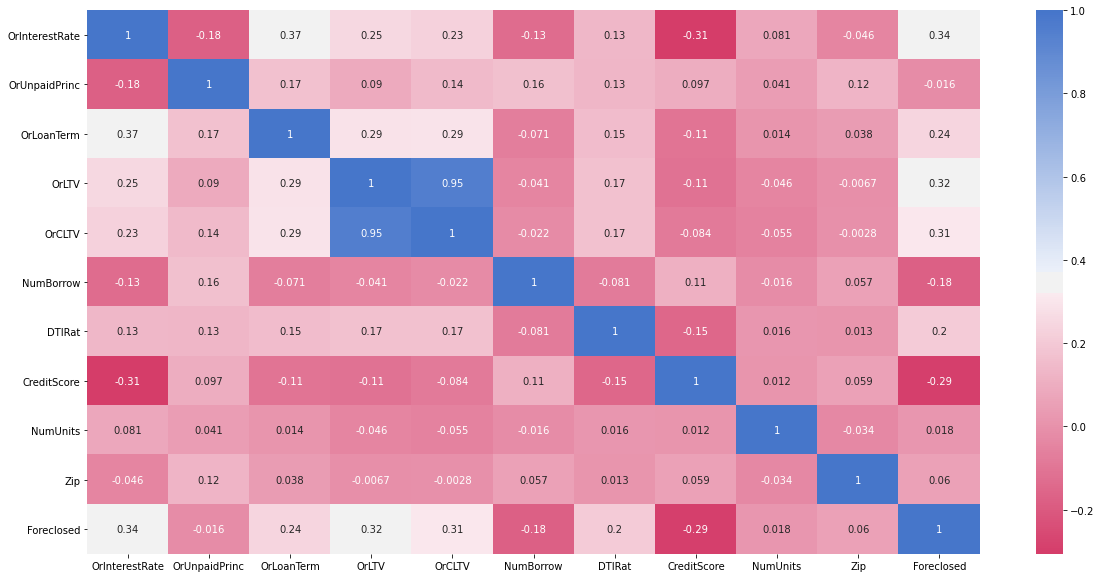

In [276]:
import matplotlib.pyplot as plt

# Calculate correlation matrix (measures correlation between attributes and target variable)
corrMatrix = df.corr()
plt.subplots(figsize=(20,10))
cmap = sns.diverging_palette(0,255,sep=10, as_cmap=True)
sns.heatmap(corrMatrix, xticklabels=corrMatrix.columns, yticklabels=corrMatrix.columns, annot=True, cmap=cmap)

In order to get a general overview of the data, I plotted a correlation matrix (Numpacharoen, 1), which measures the correlation between the different attributes that we have and the target variable. From the matrix above, we can see that some of the highest correlation to the target variable exists in the columns: OrInterestRate, OrLTV, OrCLTV, OrLoanTerm. Also, as expected, CreditScore seems to have a negative correlation to the target variable of Foreclosed. The correlation matrix above provides a high level overview of our attributes, we can dive deeper into the data and compare the different attributes we have.

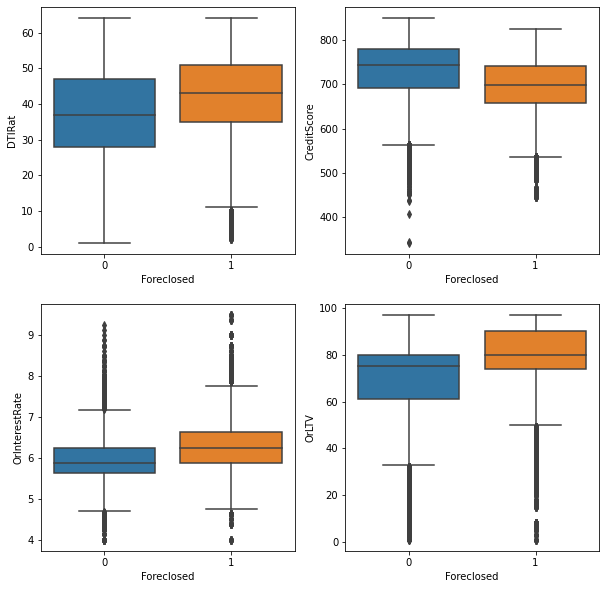

In [220]:
import matplotlib.pyplot as plt
columns = ['DTIRat','CreditScore','OrInterestRate', 'OrLTV']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

for i, y in zip([1,2,3,4], columns):
    plt.subplot(2,2,i)
    sns.boxplot(x="Foreclosed", y=y, data=df)

It was worth exploring the possibility of covariance between the credit score and interest rate variables as it is likely that someone with a low credit score will be charged a high interest rate on their loan. I plotted these two variables on a scatter plot, however, there doesn’t seem to be much correlation between the data.

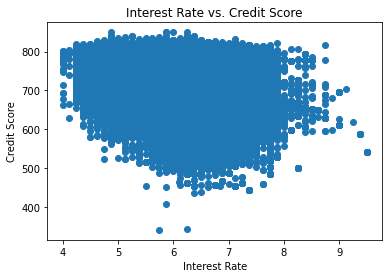

In [221]:
x = df['OrInterestRate']
y = df['CreditScore']
plt.scatter(x, y)
plt.title("Interest Rate vs. Credit Score")
plt.xlabel("Interest Rate")
plt.ylabel("Credit Score")
plt.show()

We can map the distribution of the credit score along with the likelihood of default at various levels. From the plot below, we can see very clearly that having a lower credit score leads to a higher number of defaults, which is in line with what we expect.

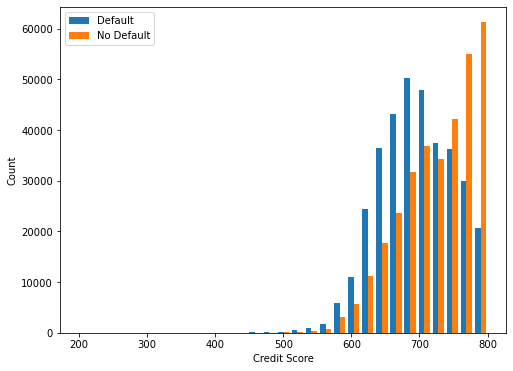

In [222]:
default_credit_score = df.loc[df['Foreclosed'] == 1, 'CreditScore']
non_default_credit_score = df.loc[df['Foreclosed'] == 0, 'CreditScore']

plt.figure(figsize=(8,6), edgecolor='blue')
plt.hist([default_credit_score, non_default_credit_score], np.linspace(200, 800, 30), label=['Default', 'No Default'],)
plt.legend(loc='upper left')
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.show()

We can map the distribution of the debt to income ratio along with the likelihood of default at various levels. From the plot below, we can see that having a higher debt to income ratio leads to a higher number of defaults, which is expected since people with higher levels of debt will likely have more trouble paying off the loan.

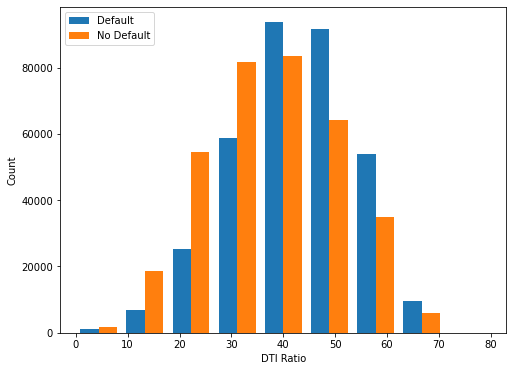

In [223]:
default_dti_ratio = df.loc[df['Foreclosed'] == 1, 'DTIRat']
non_default_dti_ratio = df.loc[df['Foreclosed'] == 0, 'DTIRat']

plt.figure(figsize=(8,6), edgecolor='blue')
plt.hist([default_dti_ratio, non_default_dti_ratio], np.linspace(0, 80, 10), label=['Default', 'No Default'],)
plt.legend(loc='upper left')
plt.xlabel("DTI Ratio")
plt.ylabel("Count")
plt.show()

We can map the distribution of the original interest rate along with the likelihood of default at various levels. From the plot below, we can see that having a higher interest rate leads to a higher number of defaults, which is expected since people with higher interest rates will likely have more trouble paying off the loan due to the extra interest that gets accumulated as well.

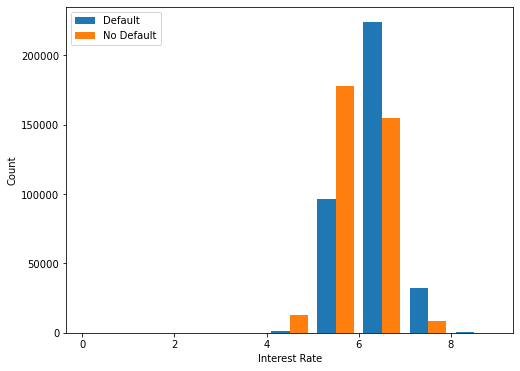

In [224]:
default_ir = df.loc[df['Foreclosed'] == 1, 'OrInterestRate']
non_default_ir = df.loc[df['Foreclosed'] == 0, 'OrInterestRate']

plt.figure(figsize=(8,6), edgecolor='blue')
plt.hist([default_ir, non_default_ir], np.linspace(0, 9, 10), label=['Default', 'No Default'],)
plt.legend(loc='upper left')
plt.xlabel("Interest Rate")
plt.ylabel("Count")
plt.show()

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709416 entries, 0 to 85201
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Channel         709416 non-null  object 
 1   SellerName      709416 non-null  object 
 2   OrInterestRate  709415 non-null  float64
 3   OrUnpaidPrinc   709416 non-null  int64  
 4   OrLoanTerm      709416 non-null  int64  
 5   OrDate          709416 non-null  object 
 6   FirstPayment    709416 non-null  object 
 7   OrLTV           709416 non-null  int64  
 8   OrCLTV          709416 non-null  int64  
 9   NumBorrow       709289 non-null  float64
 10  DTIRat          685605 non-null  float64
 11  CreditScore     708633 non-null  float64
 12  FTHomeBuyer     709416 non-null  object 
 13  LoanPurpose     709416 non-null  object 
 14  PropertyType    709416 non-null  object 
 15  NumUnits        709416 non-null  int64  
 16  OccStatus       709416 non-null  object 
 17  PropertySta

In [226]:
df['ProductType'].value_counts()

FRM    709416
Name: ProductType, dtype: int64

In [227]:
# Drop ProductType since it has only one value
df.drop(['ProductType'], axis=1, inplace=True)

We now have 10 columns where the types are not numerical so we need to alter those in order to be able to feed that data to our model. We will do that using a variety of techniques. For the OrDate and FirstPayment columns, they are input as month/year and so we can split those up into two separate columns.

In [228]:
def getMonth (record):
    return record.split('/')[0].strip()

def getYear (record):
    return record.split('/')[1].strip()
df['OrMonth'] = df['OrDate'].apply(lambda record: getMonth(record))
df['OrYear'] = df['OrDate'].apply(lambda record: getYear(record))

df['FirstPayment_Month'] = df['FirstPayment'].apply(lambda record: getMonth(record))
df['FirstPayment_Year'] = df['FirstPayment'].apply(lambda record: getYear(record))

df[['OrMonth', 'OrYear', 'FirstPayment_Month', 'FirstPayment_Year']] = df[['OrMonth', 'OrYear', 'FirstPayment_Month', 'FirstPayment_Year']].apply(pd.to_numeric)

# Drop the original columns since we have split them up into month and year
df.drop(['OrDate','FirstPayment'], axis=1, inplace=True)

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709416 entries, 0 to 85201
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Channel             709416 non-null  object 
 1   SellerName          709416 non-null  object 
 2   OrInterestRate      709415 non-null  float64
 3   OrUnpaidPrinc       709416 non-null  int64  
 4   OrLoanTerm          709416 non-null  int64  
 5   OrLTV               709416 non-null  int64  
 6   OrCLTV              709416 non-null  int64  
 7   NumBorrow           709289 non-null  float64
 8   DTIRat              685605 non-null  float64
 9   CreditScore         708633 non-null  float64
 10  FTHomeBuyer         709416 non-null  object 
 11  LoanPurpose         709416 non-null  object 
 12  PropertyType        709416 non-null  object 
 13  NumUnits            709416 non-null  int64  
 14  OccStatus           709416 non-null  object 
 15  PropertyState       709416 non-null

In [230]:
# Transform the columns with object type
df = pd.get_dummies(df, columns=['Channel', 'SellerName', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType', 'OccStatus', 'PropertyState', 'RelMortInd'])

In [231]:
# Fill columns that had null values with the mode values of those columns
df = df.fillna(df['DTIRat'].value_counts().index[0])
df = df.fillna(df['NumBorrow'].value_counts().index[0])
df = df.fillna(df['CreditScore'].value_counts().index[0])
df = df.fillna(df['OrInterestRate'].value_counts().index[0])

We can now pre-process the data set so that our models can be trained better. We will normalize it so that all attributes have values between 0 and 1.

In [232]:
# scale all the data we have so it's between the 0 and 1 range
from sklearn import preprocessing
df_minmax = preprocessing.MinMaxScaler().fit(df)
df = pd.DataFrame(df_minmax.transform(df), index=df.index, columns=df.columns)
df_normalized = pd.DataFrame(df, columns=df.columns, index=df.index)
df_normalized.describe()

,OrInterestRate,OrUnpaidPrinc,OrLoanTerm,OrLTV,OrCLTV,NumBorrow,DTIRat,CreditScore,NumUnits,Zip,...,PropertyState_UT,PropertyState_VA,PropertyState_VI,PropertyState_VT,PropertyState_WA,PropertyState_WI,PropertyState_WV,PropertyState_WY,RelMortInd_N,RelMortInd_Y
count,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,...,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000
mean,0.052875,0.242500,0.926035,0.772937,0.609161,0.011211,0.619278,0.832626,0.014752,0.538179,...,0.015365,0.027480,0.000237,0.001751,0.037335,0.026685,0.002991,0.002798,0.996617,0.003383
std,0.013641,0.123327,0.192358,0.157709,0.122632,0.017793,0.195623,0.077792,0.089441,0.297428,...,0.122999,0.163478,0.015387,0.041805,0.189581,0.161162,0.054610,0.052823,0.058066,0.058066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.043750,0.146283,1.000000,0.708333,0.556452,0.000000,0.476190,0.780397,0.000000,0.298087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.053125,0.223022,1.000000,0.822917,0.637097,0.000000,0.634921,0.836228,0.000000,0.528701,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.062500,0.323741,1.000000,0.875000,0.717742,0.023256,0.761905,0.895782,0.000000,0.840886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Building the logistic regression model

In order to build the algorithms, we are going to split the training data into a train-test split.

In [233]:
from sklearn.model_selection import train_test_split
# assign all but Foreclosed data columns to X and the Foreclosed to y since that is our target
X = df_normalized.drop(['Foreclosed'], axis=1).values
y = df_normalized['Foreclosed'].values

# create train-test split for the data we have to train and tune models
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 123)

In [241]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Find best parameters for Logistic regression (Vabalas, 8)
params_lr = { 'penalty':['l1', 'l2', 'elasticnet', 'none'],
         'C':[0.01,0.1,1,10,100],
         'max_iter': [50, 100, 200, 500, 1000],
         'class_weight':['balanced',None]}
logistic_regression = GridSearchCV(LogisticRegression(), param_grid=params_lr, n_jobs=-1)

# Train the model we generated
logistic_regression.fit(x_train,y_train)
logistic_regression.best_params_

{'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}

In [264]:
# Get predictions for the test set
prediction = logistic_regression.predict(x_test)

# Calculate the accuracy and f1 scores
lr_accuracy_score = accuracy_score(y_test,prediction)
lr_f1_score = f1_score(y_test, prediction)

# Output the confusion matrix and the classification report
print("\033[1mConfusion Matrix\033[0m\n")
print(confusion_matrix(y_test, prediction))
print("\n\033[1mClassification Report\033[0m\n")
print(classification_report(y_test, prediction))

# Output the accuracy and f1 scores
print("Accuracy score: ", round(lr_accuracy_score, 2))
print("F1 score: ", round(lr_f1_score, 2))

Confusion Matrix

[[77192 29087]
 [23340 83206]]

Classification Report

              precision    recall  f1-score   support

         0.0       0.77      0.73      0.75    106279
         1.0       0.74      0.78      0.76    106546

    accuracy                           0.75    212825
   macro avg       0.75      0.75      0.75    212825
weighted avg       0.75      0.75      0.75    212825

Accuracy score:  0.75
F1 score:  0.76


Area under curve:
0.83


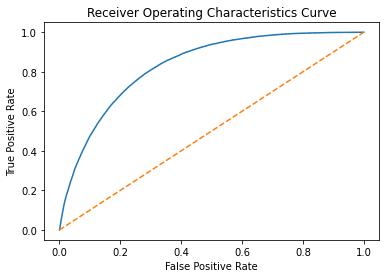

In [243]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_roc_predictions = logistic_regression.predict_proba(x_test)

# calculate area under the curve
print("Area under curve:")
print(round(roc_auc_score(y_test, lr_roc_predictions[:,1]),2))

fpr, tpr, _ = roc_curve(y_test, lr_roc_predictions[:,1])

# plot the roc curve
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristics Curve')
plt.show()

## Conclusion

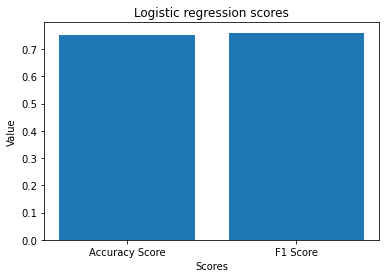

In [244]:
# accuracy/f1 score plot
plt.bar(['Accuracy Score', 'F1 Score'], [accuracy_score, f1_score])
plt.title('Logistic regression scores')
plt.xlabel('Scores')
plt.ylabel('Value')
plt.show()

After collecting results from all the logistic regression model, we can see analyze them to see how it performed. From the table and graphs above, we can see that model had an accuracy score of 75% and an f1 score of 76%. These numbers are good and were futher backed up by the area under curve metric, which came in at 0.83.

#### Hypotheses validation

The two hypotheses that were set out at the beginning of this analysis were:
* Credit score is inversely correlated with our target variable
* Original interest rate is correlated with our target variable

Both of these hypotheses were proven to be true and the plots during our data exploration show these to be true. A correlation matrix was plotted, which showed the correlation between the attributes and the target variable. These were the values that were seen for the two attributes mentioned above:
* Credit score: -0.29
* Original interest rate: 0.34

These correlation values show that the credit score attribute is inversely correlated with our target variable while the original interest rate attribute is positively correlated with our target variable.

#### Future Improvements

In the future, to improve these results, the categorical columns could be handled slightly differently by analyzing the frequencies of each of the occurences combined with their correlation to the target variable. Also, instead of filling in the missing values with the column mode, we could use another predictive model to fill in the values. Another idea to improve the model would be to compare it to some of the other algorithms (K-nearest neighbors, NBC, Decision tree, etc.) in order to see which model suits this dataset and problem type.

### Bibliography

Vabalas, Andrius, et al. “Machine Learning Algorithm Validation with a Limited Sample Size.” Plos One, vol. 14, no. 11, 2019, doi:10.1371/journal.pone.0224365.

Chawla, N. V., et al. “SMOTE: Synthetic Minority Over-Sampling Technique.” Journal of Artificial Intelligence Research, vol. 16, 2002, pp. 321–357., doi:10.1613/jair.953.

Numpacharoen, Kawee, and Amporn Atsawarungruangkit. “Generating Correlation Matrices Based on the Boundaries of Their Coefficients.” PLoS ONE, vol. 7, no. 11, 2012, doi:10.1371/journal.pone.0048902.